# Rainfall Weather Forecasting By Saurabh Lad

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import matplotlib.gridspec as gridspec
import itertools
from sklearn.utils import resample
import warnings
warnings.filterwarnings("ignore")

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, plot_confusion_matrix, roc_curve, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions

In [2]:
df=pd.read_csv('weatherAUS.csv')

In [3]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [4]:
df.shape

(8425, 23)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8425 entries, 0 to 8424
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           8425 non-null   object 
 1   Location       8425 non-null   object 
 2   MinTemp        8350 non-null   float64
 3   MaxTemp        8365 non-null   float64
 4   Rainfall       8185 non-null   float64
 5   Evaporation    4913 non-null   float64
 6   Sunshine       4431 non-null   float64
 7   WindGustDir    7434 non-null   object 
 8   WindGustSpeed  7434 non-null   float64
 9   WindDir9am     7596 non-null   object 
 10  WindDir3pm     8117 non-null   object 
 11  WindSpeed9am   8349 non-null   float64
 12  WindSpeed3pm   8318 non-null   float64
 13  Humidity9am    8366 non-null   float64
 14  Humidity3pm    8323 non-null   float64
 15  Pressure9am    7116 non-null   float64
 16  Pressure3pm    7113 non-null   float64
 17  Cloud9am       6004 non-null   float64
 18  Cloud3pm

In [6]:
df['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
df['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

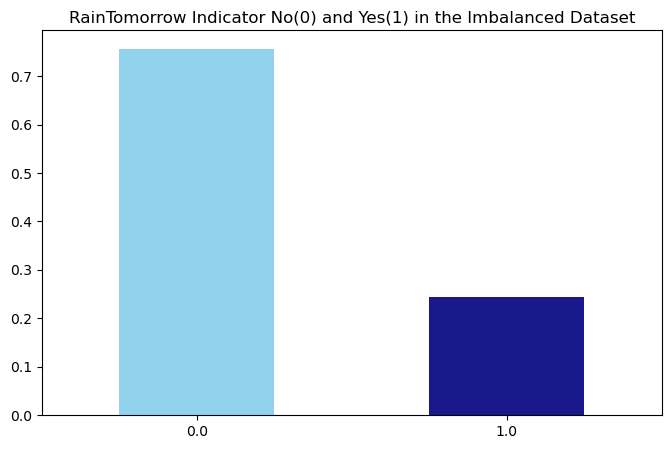

In [7]:

fig = plt.figure(figsize = (8,5))
df.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

We can observe that the presence of “0” and “1” is almost in the 78:22 ratio. So there is a class imbalance and we have to deal with it. To fight against the class imbalance, we will use here the oversampling of the minority class. Since the size of the dataset is quite small, majority class subsampling wouldn’t make much sense here.

## Handling class imbalance for rainfall prediction

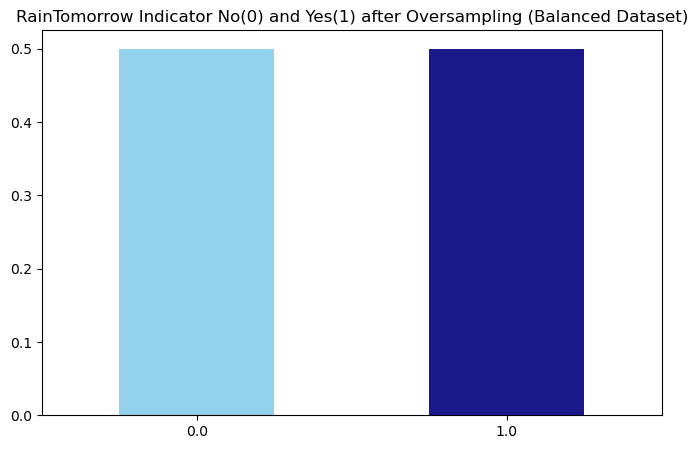

In [8]:


no = df[df.RainTomorrow == 0]
yes = df[df.RainTomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

fig = plt.figure(figsize = (8,5))
oversampled.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

## Missing Data

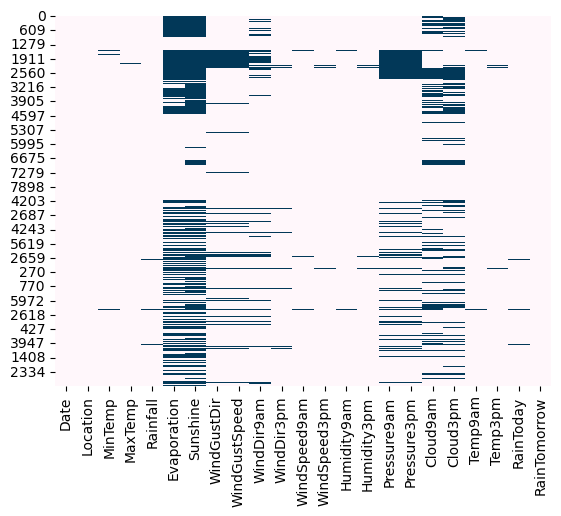

In [9]:

sns.heatmap(oversampled.isnull(), cbar=False, cmap='PuBu')
plt.show()

“Evaporation”, “Sunshine”, “Cloud9am”, “Cloud3pm” are the features with a high missing percentage. So we will check the details of the missing data for these 4 features.

In [10]:
total = oversampled.isnull().sum().sort_values(ascending=False)
percent = (oversampled.isnull().sum()/oversampled.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head(4)

,Total,Percent
Sunshine,5886,0.475061
Evaporation,5186,0.418563
Cloud9am,3202,0.258434
Cloud3pm,3197,0.258031


4 features have less than 50 per cent missing data. So instead of rejecting them completely, we’ll consider them in our model with proper imputation.

## Imputation and Transformation

In [11]:
oversampled.select_dtypes(include=['object']).columns

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [12]:
# Impute categorical var with Mode

oversampled['Date'] = oversampled['Date'].fillna(oversampled['Date'].mode()[0])
oversampled['Location'] = oversampled['Location'].fillna(oversampled['Location'].mode()[0])
oversampled['WindGustDir'] = oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0])
oversampled['WindDir9am'] = oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0])
oversampled['WindDir3pm'] = oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0])

In [13]:
df2 = oversampled[['Location','WindGustDir', 'WindDir9am' ,'WindDir3pm']]

In [14]:
# Convert categorical features to continuous features with Label Encoding

lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])

In [15]:
oversampled.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,0,1,13.4,22.9,0.6,NaN,NaN,13,44.0,13,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,0.0,0.0
1,1,1,7.4,25.1,0.0,NaN,NaN,14,44.0,6,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,0.0,0.0
2,2,1,12.9,25.7,0.0,NaN,NaN,15,46.0,13,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,0.0,0.0
3,3,1,9.2,28.0,0.0,NaN,NaN,4,24.0,9,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,0.0,0.0
4,4,1,17.5,32.3,1.0,NaN,NaN,13,41.0,1,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0.0,0.0


In [16]:
# Multiple Imputation by Chained Equations

MiceImputed = oversampled.copy(deep=True) 
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(oversampled)

We will now detect and eliminate outliers from the inter-quartile interval-based data set.

In [17]:
# Detecting outliers with IQR

Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Date             1431.750000
Location            5.000000
MinTemp             8.300000
MaxTemp             8.400000
Rainfall            3.200000
Evaporation         4.238617
Sunshine            6.344000
WindGustDir         9.000000
WindGustSpeed      20.000000
WindDir9am          9.000000
WindDir3pm          7.000000
WindSpeed9am       13.000000
WindSpeed3pm       15.000000
Humidity9am        24.000000
Humidity3pm        27.123541
Pressure9am         8.200000
Pressure3pm         8.000000
Cloud9am            4.068659
Cloud3pm            4.000000
Temp9am             8.000000
Temp3pm             8.075000
RainToday           1.000000
RainTomorrow        1.000000
dtype: float64


In [18]:
# Removing outliers from the dataset
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
MiceImputed.shape

(9748, 23)

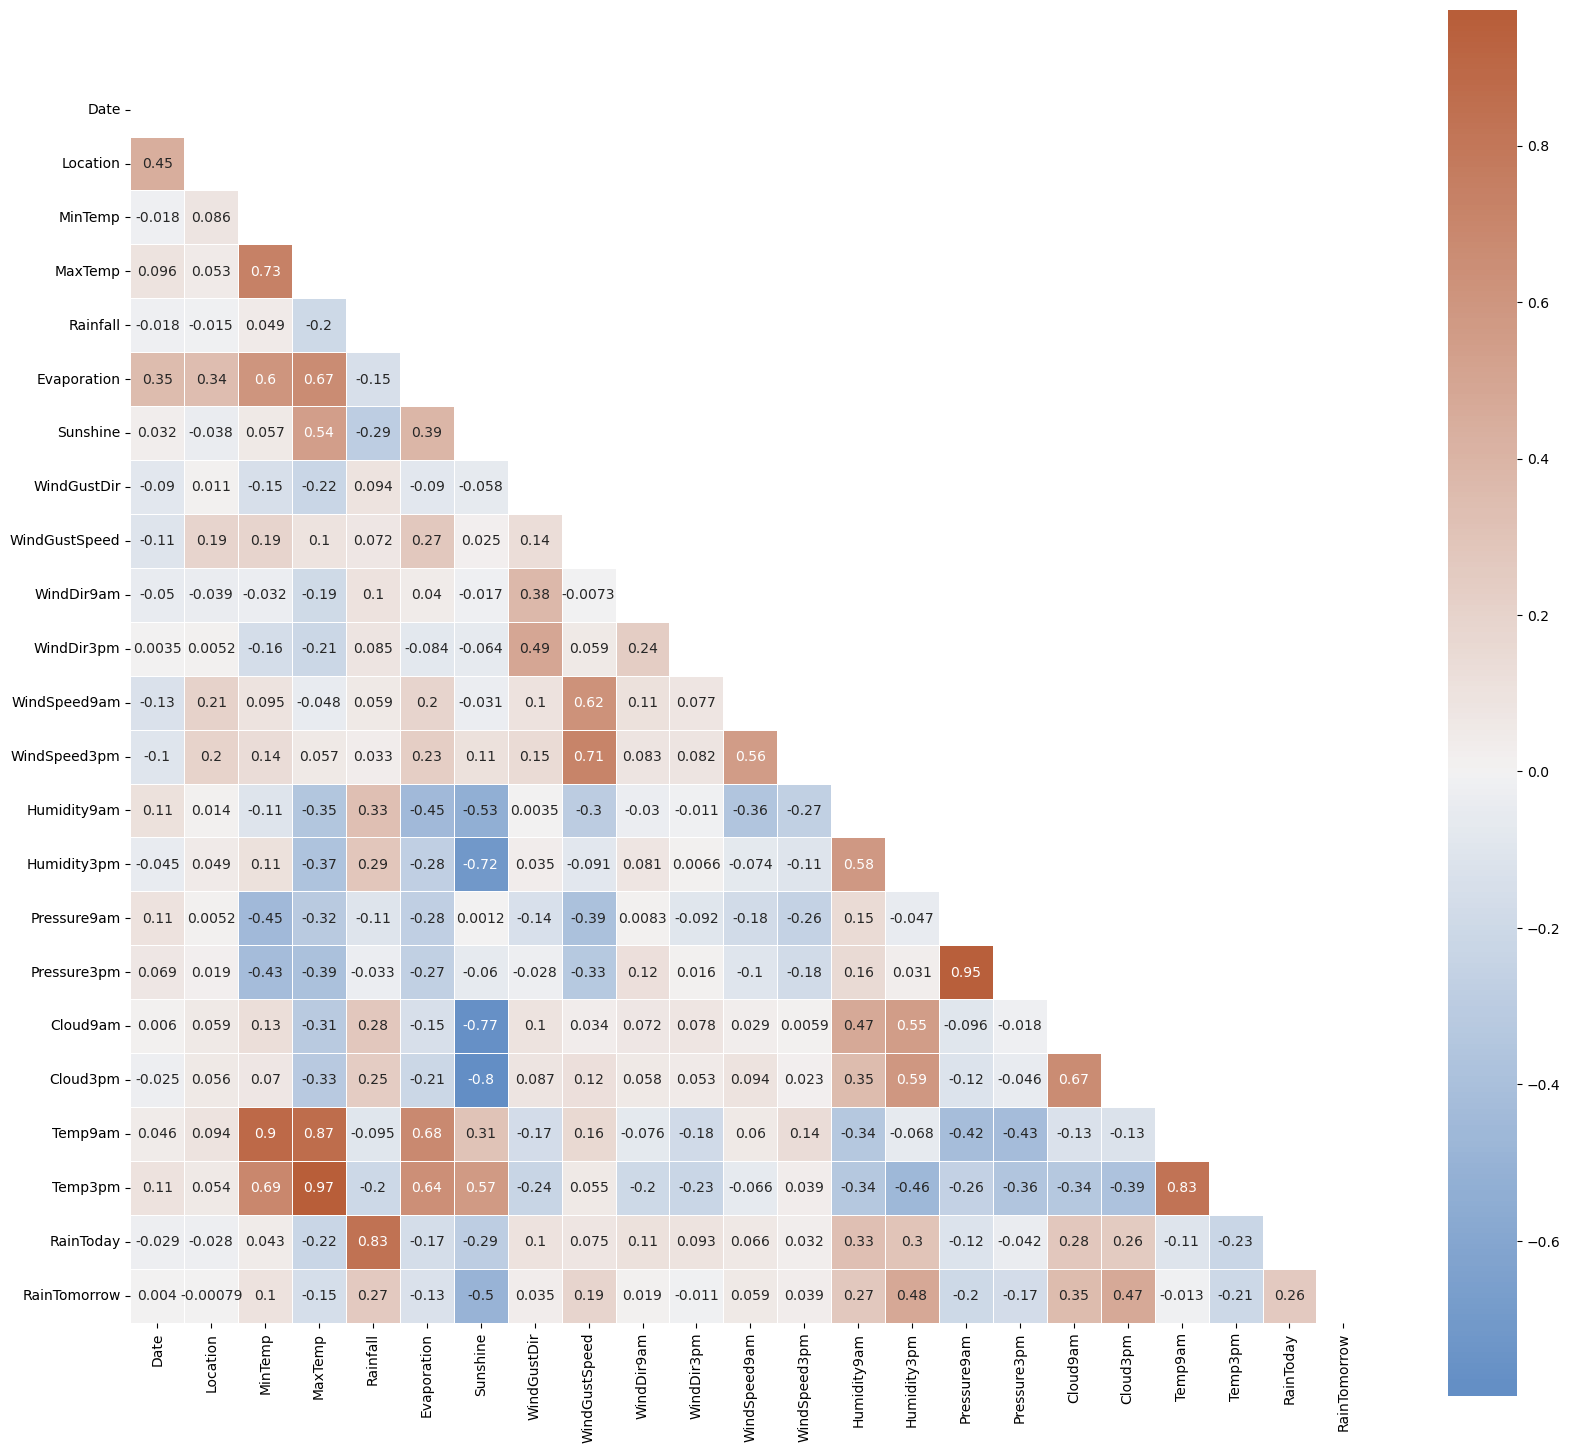

In [19]:
# Correlation Heatmap

corr = MiceImputed.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})
plt.show()

The following feature pairs have a strong correlation with each other:

- MaxTemp and MinTemp
- Pressure9h and pressure3h
- Temp9am and Temp3pm
- Evaporation and MaxTemp
- MaxTemp and Temp3pm 

But in no case is the correlation value equal to a perfect “1”. We are therefore not removing any functionality

In [ ]:
sns.pairplot( data=MiceImputed, vars=('MaxTemp','MinTemp','Pressure9am','Pressure3pm', 'Temp9am', 'Temp3pm', 'Evaporation'), hue='RainTomorrow' )
plt.show()

## Feature Selection for Rainfall Prediction

I will use both the filter method and the wrapper method(random forest) for feature selection to train our rainfall prediction model.

### Filter Method (Chi-Square)

Using MinMaxScaler instead of StandardScaler in order to avoid negative values.

In [21]:
# Standardizing data

r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed), index=MiceImputed.index, columns=MiceImputed.columns)

In [22]:
# Feature Importance using Filter Method (Chi-Square)

X = modified_data.loc[:,modified_data.columns!='RainTomorrow']
y = modified_data[['RainTomorrow']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index(['Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Cloud9am', 'Cloud3pm', 'Temp3pm', 'RainToday'],
      dtype='object')


We can observe that “Sunshine”, “Humidity9am”, “Humidity3pm”, “Pressure9am”, “Pressure3pm” have higher importance compared to other features.

### Wrapping Method (Random Forest)

In [23]:

X = MiceImputed.drop('RainTomorrow', axis=1)
y = MiceImputed['RainTomorrow']
selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=0))
selector.fit(X, y)
support = selector.get_support()
features = X.loc[:,support].columns.tolist()
print(features)
print(RandomForestClassifier(n_estimators=100, random_state=0).fit(X,y).feature_importances_)

['Date', 'Sunshine', 'WindGustSpeed', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud3pm']
[0.04552285 0.02167373 0.03696247 0.03299921 0.02891997 0.0351255
 0.1177546  0.02179026 0.05071181 0.02497631 0.0259351  0.02587539
 0.02833827 0.04441683 0.11580411 0.04671925 0.05793059 0.04206377
 0.10439172 0.03533102 0.03867535 0.0180819 ]


#### Selecting features by filtering method (chi-square value).

## Training Rainfall Prediction Model with Different Models

In [24]:
features = MiceImputed[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 
                       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
                       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 
                       'RainToday']]
target = MiceImputed['RainTomorrow']

# Split into test and train

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

# Normalize Features

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [25]:
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [26]:

def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0 = time.time()
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred) 
    coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time()-t0
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Cohen's Kappa = {}".format(coh_kap))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_test,y_pred,digits=5))
    
    probs = model.predict_proba(X_test)  
    probs = probs[:, 1]  
    fper, tper, thresholds = roc_curve(y_test, probs) 
    plot_roc_cur(fper, tper)
    
    plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Blues, normalize = 'all')
    
    return model, accuracy, roc_auc, coh_kap, time_taken

Accuracy = 0.7821091505949939
ROC Area under Curve = 0.7767197742925899
Cohen's Kappa = 0.5570463526967333
Time taken = 0.20308184623718262
              precision    recall  f1-score   support

         0.0    0.78491   0.83122   0.80740      1339
         1.0    0.77821   0.72222   0.74917      1098

    accuracy                        0.78211      2437
   macro avg    0.78156   0.77672   0.77829      2437
weighted avg    0.78189   0.78211   0.78117      2437



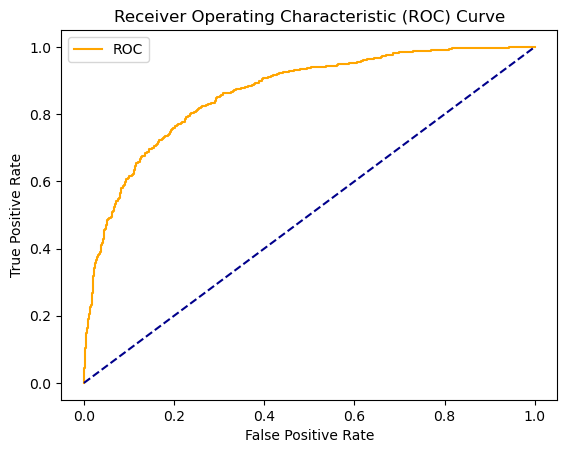

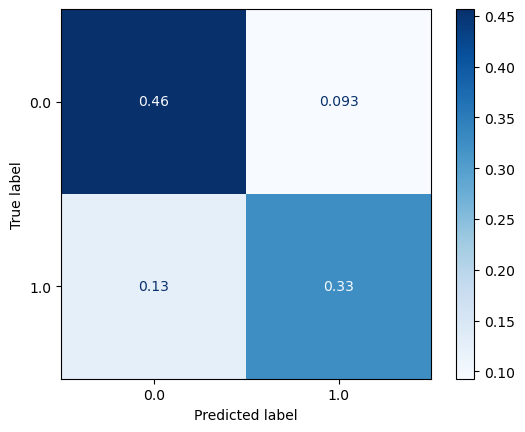

In [27]:
# Logistic Regression


params_lr = {'penalty': 'l1', 'solver':'liblinear'}

model_lr = LogisticRegression(**params_lr)
model_lr, accuracy_lr, roc_auc_lr, coh_kap_lr, tt_lr = run_model(model_lr, X_train, y_train, X_test, y_test)


Accuracy = 0.8674599917931883
ROC Area under Curve = 0.8648806098670813
Cohen's Kappa = 0.731620100150939
Time taken = 0.05212068557739258
              precision    recall  f1-score   support

         0.0    0.87080   0.89096   0.88077      1339
         1.0    0.86317   0.83880   0.85081      1098

    accuracy                        0.86746      2437
   macro avg    0.86699   0.86488   0.86579      2437
weighted avg    0.86736   0.86746   0.86727      2437



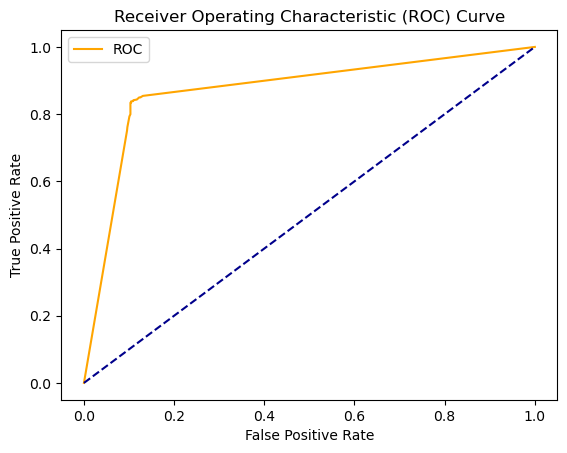

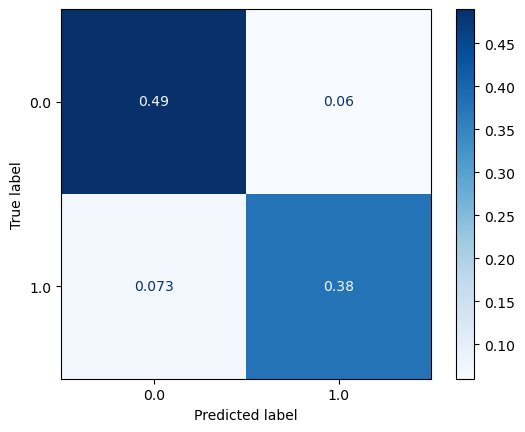

In [28]:
# Decision Tree


params_dt = {'max_depth': 16,
             'max_features': "sqrt"}

model_dt = DecisionTreeClassifier(**params_dt)
model_dt, accuracy_dt, roc_auc_dt, coh_kap_dt, tt_dt = run_model(model_dt, X_train, y_train, X_test, y_test)


Accuracy = 0.9199835863766926
ROC Area under Curve = 0.9216111580427989
Cohen's Kappa = 0.8391643987825346
Time taken = 23.56037425994873
              precision    recall  f1-score   support

         0.0    0.94688   0.90515   0.92554      1339
         1.0    0.89023   0.93807   0.91353      1098

    accuracy                        0.91998      2437
   macro avg    0.91855   0.92161   0.91953      2437
weighted avg    0.92135   0.91998   0.92013      2437



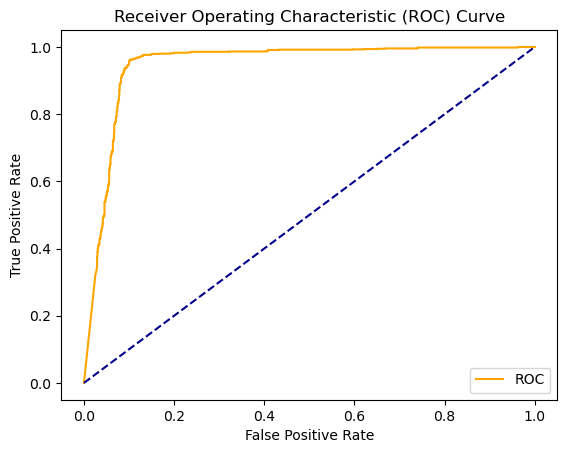

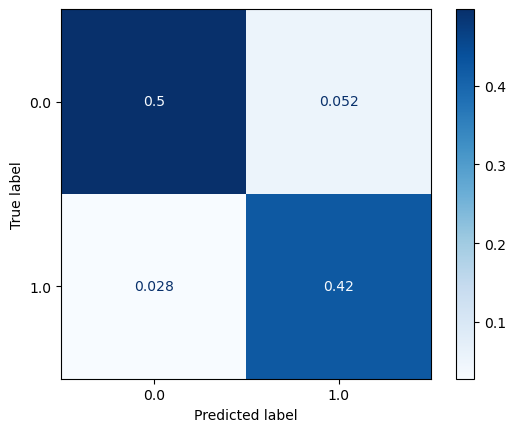

In [29]:
# Neural Network

params_nn = {'hidden_layer_sizes': (30,30,30),
             'activation': 'logistic',
             'solver': 'lbfgs',
             'max_iter': 500}

model_nn = MLPClassifier(**params_nn)
model_nn, accuracy_nn, roc_auc_nn, coh_kap_nn, tt_nn = run_model(model_nn, X_train, y_train, X_test, y_test)


Accuracy = 0.9573245794009028
ROC Area under Curve = 0.9579685924982757
Cohen's Kappa = 0.9139895001544095
Time taken = 6.948032855987549
              precision    recall  f1-score   support

         0.0    0.97030   0.95146   0.96078      1339
         1.0    0.94217   0.96448   0.95320      1098

    accuracy                        0.95732      2437
   macro avg    0.95623   0.95797   0.95699      2437
weighted avg    0.95762   0.95732   0.95737      2437



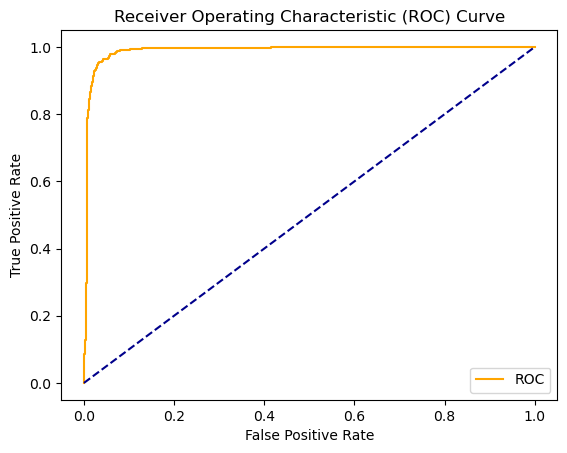

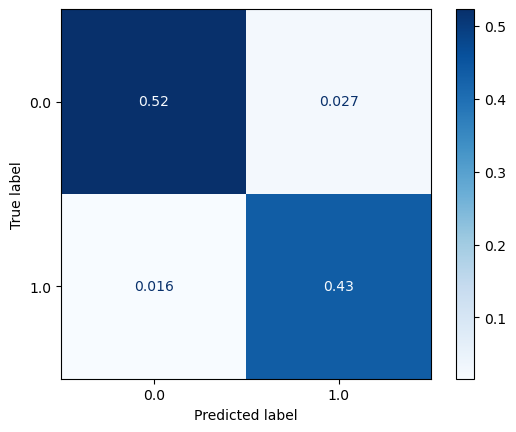

In [30]:

# XGBoost

params_xgb = {'n_estimators': 500,
            'max_depth': 16}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, accuracy_xgb, roc_auc_xgb, coh_kap_xgb, tt_xgb = run_model(model_xgb, X_train, y_train, X_test, y_test)


Accuracy = 0.9626590069757899
ROC Area under Curve = 0.9633966843102607
Cohen's Kappa = 0.9247469672892423
Time taken = 2.479686737060547
              precision    recall  f1-score   support

         0.0    0.97561   0.95594   0.96567      1339
         1.0    0.94756   0.97086   0.95906      1098

    accuracy                        0.96266      2437
   macro avg    0.96158   0.96340   0.96237      2437
weighted avg    0.96297   0.96266   0.96270      2437



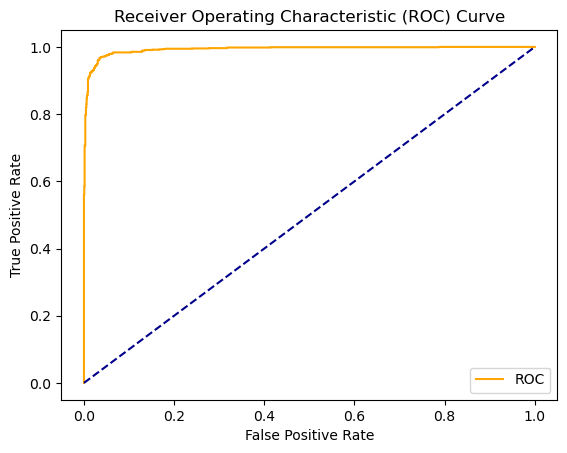

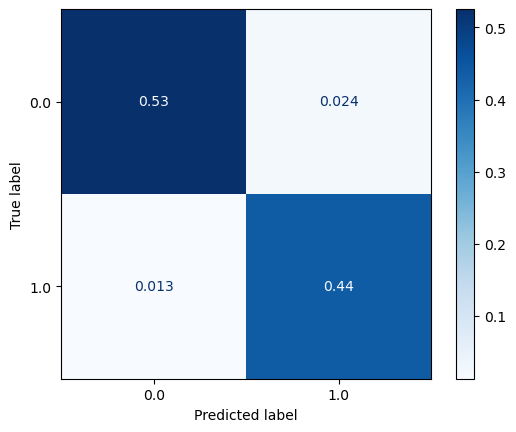

In [31]:
# Random Forest

params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 100,
             'random_state': 12345}

model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf, roc_auc_rf, coh_kap_rf, tt_rf = run_model(model_rf, X_train, y_train, X_test, y_test)


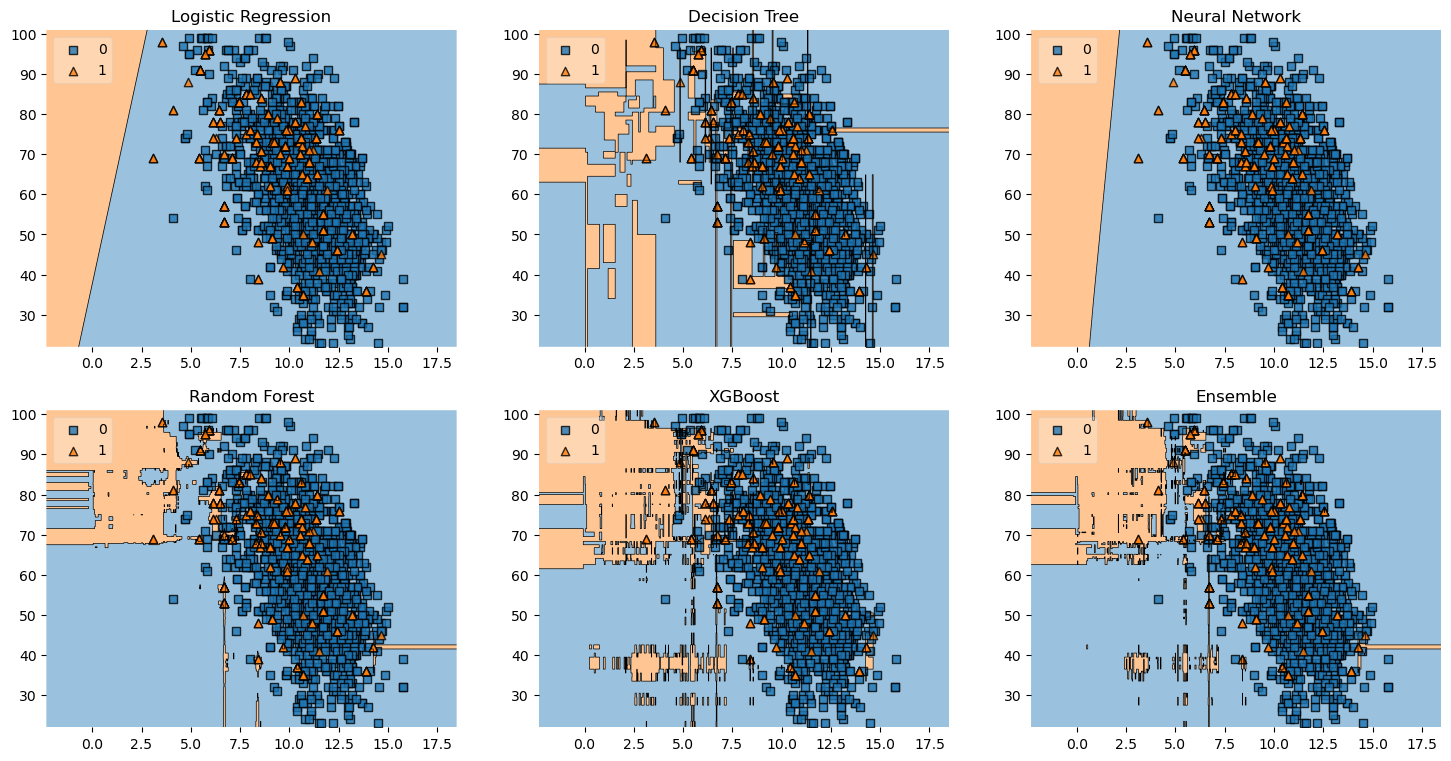

In [32]:
value = 1.80
width = 0.90

clf1 = LogisticRegression(random_state=12345)
clf2 = DecisionTreeClassifier(random_state=12345) 
clf3 = MLPClassifier(random_state=12345, verbose = 0)
clf4 = RandomForestClassifier(random_state=12345)
clf5 = xgb.XGBClassifier(random_state=12345)
eclf = EnsembleVoteClassifier(clfs=[clf4, clf5], weights=[1, 1], voting='soft')

X_list = MiceImputed[["Sunshine", "Humidity9am", "Cloud3pm"]] #took only really important features
X = np.asarray(X_list, dtype=np.float32)
y_list = MiceImputed["RainTomorrow"]
y = np.asarray(y_list, dtype=np.int32)

# Plotting Decision Regions
gs = gridspec.GridSpec(3,3)
fig = plt.figure(figsize=(18, 14))

labels = ['Logistic Regression',
          'Decision Tree',
          'Neural Network',
          'Random Forest',
          'XGBoost',
          'Ensemble']

for clf, lab, grd in zip([clf1, clf2, clf3, clf4, clf5, eclf],labels,itertools.product([0, 1, 2],repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, filler_feature_values={2: value}, filler_feature_ranges={2: width}, legend=2)
    plt.title(lab)

plt.show()

XGBoost and Random Forest models have a much lower number of misclassified data points compared to other models.

## Rainfall Prediction Model Comparison

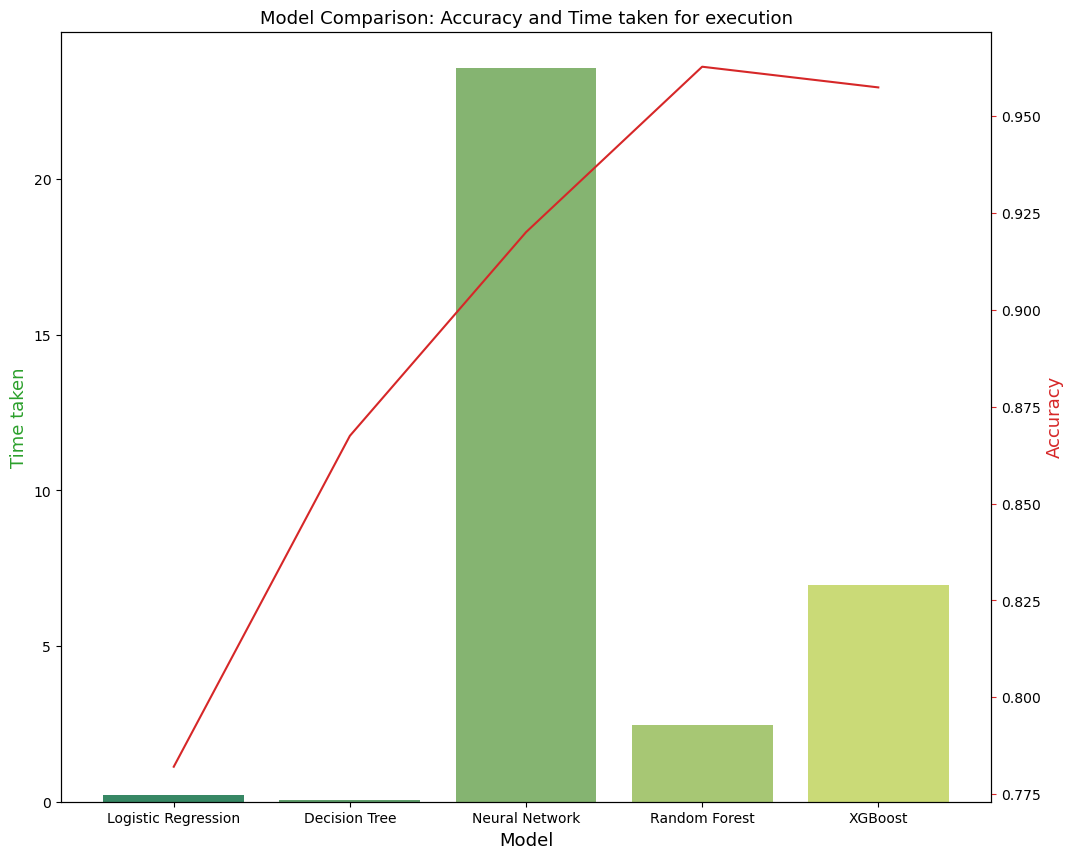

In [33]:
accuracy_scores = [accuracy_lr, accuracy_dt, accuracy_nn, accuracy_rf, accuracy_xgb]
roc_auc_scores = [roc_auc_lr, roc_auc_dt, roc_auc_nn, roc_auc_rf, roc_auc_xgb]
coh_kap_scores = [coh_kap_lr, coh_kap_dt, coh_kap_nn, coh_kap_rf, coh_kap_xgb]
tt = [tt_lr, tt_dt, tt_nn, tt_rf, tt_xgb]

model_data = {'Model': ['Logistic Regression','Decision Tree','Neural Network','Random Forest','XGBoost'],
              'Accuracy': accuracy_scores,
              'ROC_AUC': roc_auc_scores,
              'Cohen_Kappa': coh_kap_scores,
              'Time taken': tt}
data = pd.DataFrame(model_data)

fig, ax1 = plt.subplots(figsize=(12,10))
ax1.set_title('Model Comparison: Accuracy and Time taken for execution', fontsize=13)
color = 'tab:green'
ax1.set_xlabel('Model', fontsize=13)
ax1.set_ylabel('Time taken', fontsize=13, color=color)
ax2 = sns.barplot(x='Model', y='Time taken', data = data, palette='summer')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', fontsize=13, color=color)
ax2 = sns.lineplot(x='Model', y='Accuracy', data = data, sort=False, color=color)
ax2.tick_params(axis='y', color=color)

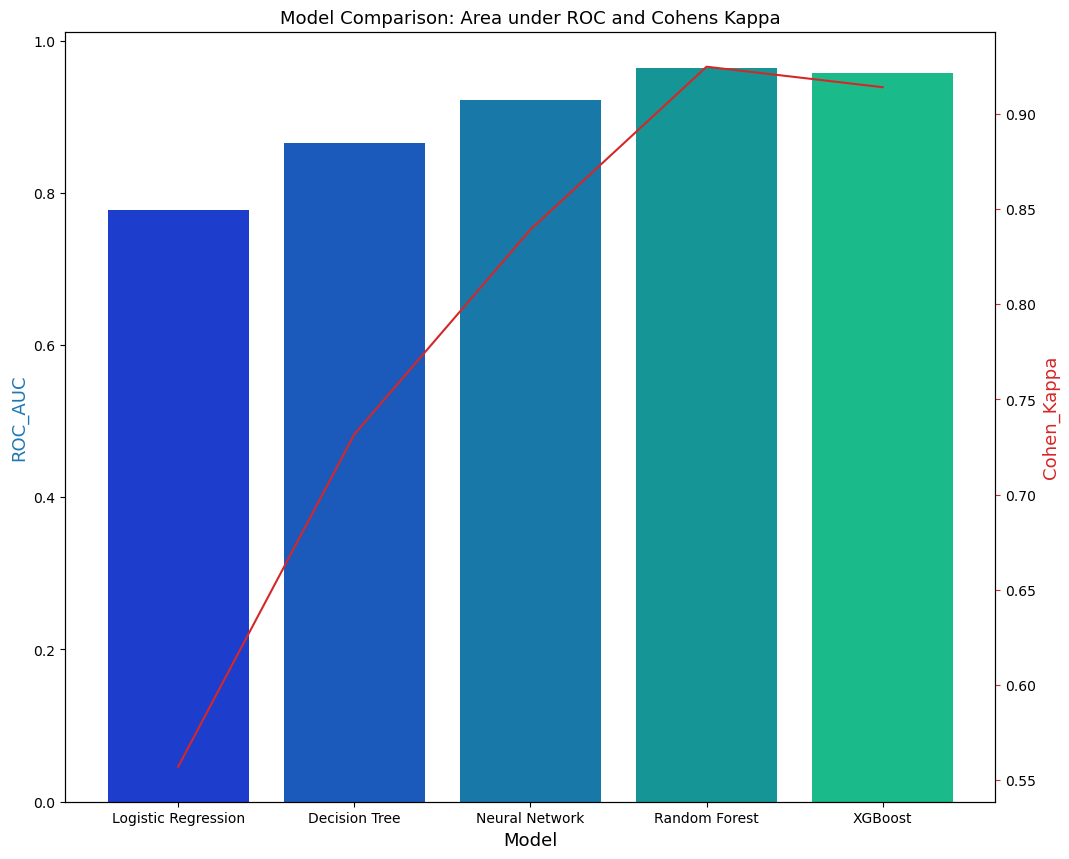

In [34]:
fig, ax3 = plt.subplots(figsize=(12,10))
ax3.set_title('Model Comparison: Area under ROC and Cohens Kappa', fontsize=13)
color = 'tab:blue'
ax3.set_xlabel('Model', fontsize=13)
ax3.set_ylabel('ROC_AUC', fontsize=13, color=color)
ax4 = sns.barplot(x='Model', y='ROC_AUC', data = data, palette='winter')
ax3.tick_params(axis='y')
ax4 = ax3.twinx()
color = 'tab:red'
ax4.set_ylabel('Cohen_Kappa', fontsize=13, color=color)
ax4 = sns.lineplot(x='Model', y='Cohen_Kappa', data = data, sort=False, color=color)
ax4.tick_params(axis='y', color=color)
plt.show()

We can observe that **XGBoost** and **Random Forest** performed better compared to other models. However, if **speed** is an important thing to consider, we can stick with **Random Forest** instead of **XGBoost**.

In [35]:
pickle.dump(model_rf, open('model_rb.pkl', 'wb'))

In [36]:
pickle.dump(model_xgb , open('model_xgb.pkl', 'wb'))

In [37]:
model =  pickle.load(open('model_xgb.pkl', 'rb'))

In [38]:
input1 = [[12,4.4,12.8,0,2.2,6.1,8,22,8,8,6,7,77,50,1022.5,1019.5,7,4,7.1,12.4,0]]
input2 = [[2,15.9,21.7,2.2,5.6,10.0,13,31.0,3,7,15.0,13.0,89.0,91.0,1010.5,1004.2,8.0,8.0,15.9,17.0,1]]

In [39]:
prediction1 = model.predict(input1) 

pred = int(prediction1[0])
if pred == 0:
    print("Tomorrow will be no Rain fall")
else:
    print("Tomorrow will be Rain fall")

Tomorrow will be Rain fall


In [40]:
prediction2 = model.predict(input2) 
pred = int(prediction2[0])
if pred == 0:
    print("Tomorrow will be no Rain fall")
else:
    print("Tomorrow will be Rain fall")

Tomorrow will be Rain fall
